# Inflows to Rainy Lake

## Rainy Lake Stage-Volume Relationship

The stage-volume relationship is needed to estimate net inflows using measured lake level and measured outflow. The following stage-volume data is courtesy of Jean Morin and the same data used by the Lake of Woods Secretariat in preparing basin data reports.

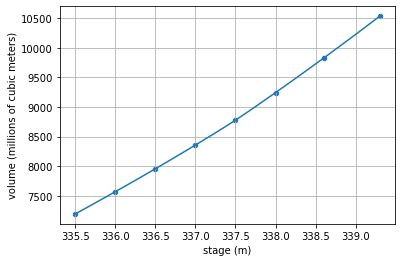

In [185]:
import numpy as np
from scipy.interpolate import interp1d

# data
df_stage_volume = pd.DataFrame(
    [[335.5,  7194.67197,  719.271],
     [336.0,  7570.67329,  770.153],
     [336.5,  7957.68641,  794.916],
     [337.0,  8358.73022,  833.198],
     [337.5,  8779.56914,  919.860],
     [338.0,  9244.10878,  966.400],
     [338.6,  9826.74905, 1011.093],
     [339.3, 10533.87720, 1048.357]],
    columns = ['stage', 'volume', 'area'])

# quadratic interpolating function
volume = interp1d(df_stage_volume['stage'], df_stage_volume['volume'], kind='quadratic')

# demonstrating with plot
ax = df_stage_volume.plot(x='stage', y='volume', kind='scatter', style='o')

x = np.linspace(df_stage_volume['stage'].min(), df_stage_volume['stage'].max())
ax.plot(x, volume(x))
ax.set_xlabel('stage (m)')
ax.set_ylabel('volume (millions of cubic meters)')
ax.grid(True)

## Rainy Lake Ice-out Data

<AxesSubplot:xlabel='year'>

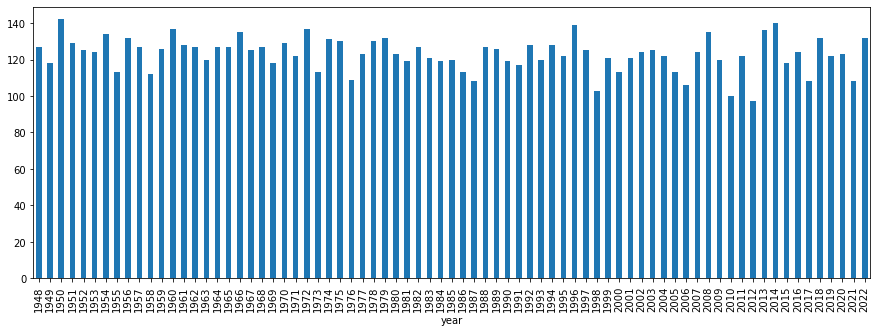

In [190]:
# get ice out dates
af = pd.read_csv( "../../data/ice_out_dates_rainy_lake.txt", skiprows=1)
af.columns = ["ice-out date", "source", "comments"]
af = af.drop(labels='source', axis=1)
af = af.drop(labels='comments', axis=1)

# Create a new independent variable counting years from the first date in the data set
af['ice-out date'] = pd.to_datetime(af['ice-out date'])
af['year'] = af['ice-out date'].dt.year
af['ice-out doy'] = af['ice-out date'].dt.dayofyear

# Drop unneeded rows
af = af[af["year"] >= 1948]
af = af.set_index("year")
af["ice-out doy"].plot(kind="bar", figsize=(15, 5))

## Read HYDAT database

In [87]:
import pandas as pd
import importlib
import sys
sys.path.insert(0, '../../python')

import hydat
importlib.reload(hydat)

# create hydat object
hydat = hydat.Hydat('../../data/Hydat.sqlite3')

## History of Rainy Lake Level and Outflows

In [194]:
import pandas as pd

# df ==> daily data 
# af ==> annual data

# get rainy lake levels and flow series
df = pd.DataFrame()
df["outflow"] = hydat.get_flows('05PC019', 1948, 2020)
df["level"] = hydat.get_levels('05PB007', 1948, 2020)
df["year"] = df.index.year
df.head()


,outflow,level,year
1948-01-01,181.0,337.727997,1948
1948-01-02,286.0,337.727997,1948
1948-01-03,300.0,337.723999,1948
1948-01-04,300.0,337.717987,1948
1948-01-05,311.0,337.714996,1948


<AxesSubplot:>

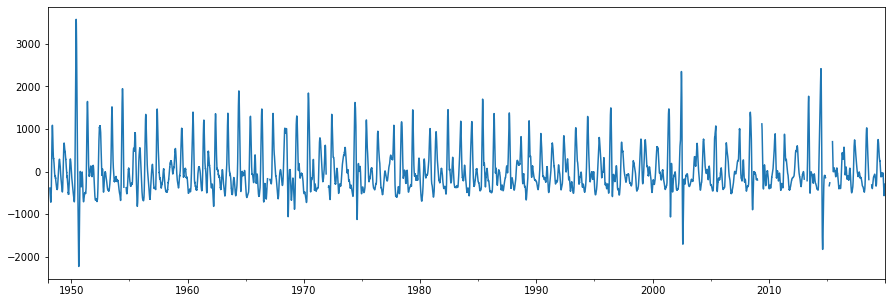

In [212]:
df["volume"] = volume(df["level"])
df["inflow"] = df["inflow"] + df["volume"].diff() * 1.0e6/86400
df["inflow"] = df["inflow"].rolling(30, center=True).mean()
df["inflow"].plot(figsize=(15, 5))

## Plot Demonstrating the History of Flooding on Rainy Lake

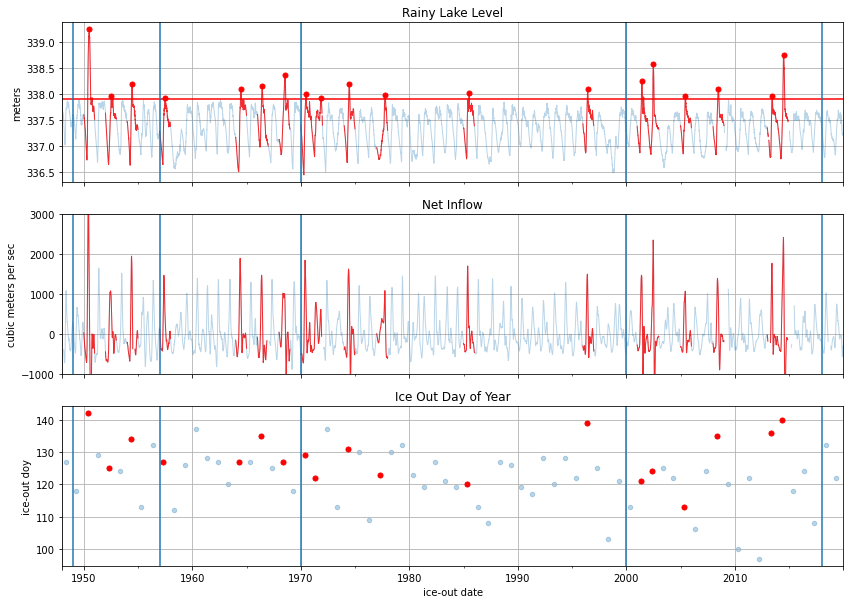

In [223]:
import matplotlib.pyplot as plt
import datetime as dt

AGO = 337.9

# create a list of flood years
floods = df.groupby(["year"])["level"].max() >= AGO
flood_years = list(floods[floods].index)

fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# plot level
df["level"].plot(ax=ax[0], alpha=0.3, lw=1, ylabel="meters", grid=True, title="Rainy Lake Level")
ax[0].axhline(AGO, color='r')

# plot flows
df["inflow"].plot(ax=ax[1], alpha=0.3, lw=1, ylabel="cubic meters per sec", grid=True, title="Net Inflow")
ax[1].set_ylim(-1000, 3000)

# plot ice out dates
af.plot(ax=ax[2], x="ice-out date", y="ice-out doy", kind="scatter", alpha=0.3, grid=True, title="Ice Out Day of Year")

# highlight flood years
for year in flood_years:
    tmp = df[df["year"] == year]["level"]
    tmp.plot(ax=ax[0], alpha=0.8, lw=1, color='r', ylabel="meters", grid=True, title="Rainy Lake Level")
    y = tmp.max()
    x = tmp[tmp==y].index.date[0]
    ax[0].plot(x, y, '.', ms=10, c='r')
    
    tmp = df[df["year"] == year]["inflow"]
    tmp.plot(ax=ax[1], alpha=0.8, lw=1, color='r', grid=True)
    
    ax[2].plot(af.loc[year, "ice-out date"], af.loc[year, "ice-out doy"], 'r.', ms=10)
    
for a in ax:
    a.axvline(dt.datetime(1949, 1, 1))
    a.axvline(dt.datetime(1957, 1, 1))
    a.axvline(dt.datetime(1970, 1, 1))
    a.axvline(dt.datetime(2000, 1, 1))
    a.axvline(dt.datetime(2018, 1, 1))

Text(0, 0.5, 'Rainy Lake Level (meters)')

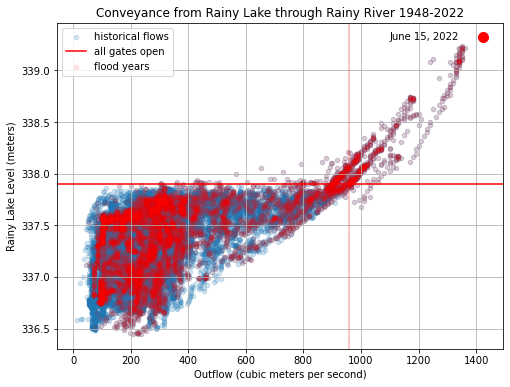

In [266]:
ax = df.plot(x="outflow", y="level", kind="scatter", figsize=(8, 6), alpha=0.2, grid=True)
ax.axhline(AGO, color='r')

# highlight flood years
for year in flood_years:
    tmp = df[df["year"] == year]
    tmp.plot(ax=ax, x="outflow", y="level", kind="scatter", alpha=0.1, lw=1, color='r', 
             ylabel="meters", grid=True, title="Rainy Lake Level")
    

ax.legend(["historical flows", "all gates open", "flood years"])
ax.axvline(960.0, color='r', alpha=0.3)

x = 1424.0
y = 339.32

plt.plot(x, y, 'r.', ms=20)
ax.text(1100, 339.3, "June 15, 2022")
ax.set_title("Conveyance from Rainy Lake through Rainy River 1948-2022")
ax.set_xlabel("Outflow (cubic meters per second)")
ax.set_ylabel("Rainy Lake Level (meters)")


## Read Rainy Lake levels and outflows

<AxesSubplot:>

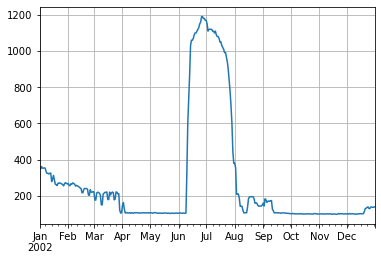

In [38]:
def flow_volume(year):
    X = pd.DataFrame()
    X['level'] = hydat.get_levels("05PB007", start=year, end=year)
    X['outflow'] = hydat.get_flows("05PC019", start=year, end=year)
    return X

df = flow_volume(2002)
df['outflow'].plot(grid=True)

## Cumulative Net Inflow

$$\frac{dV}{dt} = \text{Inflow} - \text{Outflow} - \text{losses}$$


<AxesSubplot:>

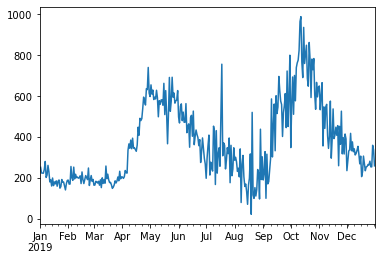

In [63]:
df = flow_volume(2019)


df['volume'] = volume(df['level']) - volume(df['level'])[0]

df['sum_inflow'] = df['outflow'].cumsum()*86400/1e6 + df['volume']
(df['sum_inflow'].diff()*1e6/86400).plot()